In [1]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-v7pp6owm because the default path (/home/a5/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc.settings.n_jobs = 36
sc.set_figure_params(figsize=(4,4), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
adata = sc.read_h5ad('Infile_BrainAtlas_sampled.20230918.h5ad')

In [5]:
# Exclude Study Olivier2021, Xie2021, GSE146165, GSE168741
adata = adata[~adata.obs['Study'].isin(['Olivier2021', 'Xie2021', 'GSE146165', 'GSE168741'])]

In [6]:
adata

View of AnnData object with n_obs × n_vars = 508375 × 36601
    obs: 'SampleID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'DonorID', 'Study', 'Series', 'PMID', 'publication_year', 'BioSample', 'Batch', 'Age', 'Age2', 'Stage', 'Region', 'PMI', 'Sex', 'Diagnosis', 'Instrument', 'Assay', 'Library', 'Category', 'redistributable', 'Region2'

In [7]:
# 1. Determine which samples have less than 100 cells
sample_counts = adata.obs['SampleID'].value_counts()
samples_to_keep = sample_counts[sample_counts >= 100].index

subset_mask = adata.obs['SampleID'].isin(samples_to_keep)

# Subset the adata object using this mask
adata = adata[subset_mask]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 492644 × 36601
    obs: 'SampleID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'DonorID', 'Study', 'Series', 'PMID', 'publication_year', 'BioSample', 'Batch', 'Age', 'Age2', 'Stage', 'Region', 'PMI', 'Sex', 'Diagnosis', 'Instrument', 'Assay', 'Library', 'Category', 'redistributable', 'Region2'

In [9]:
sc.pp.filter_genes(adata, min_cells = 3)
adata 
# 1min

AnnData object with n_obs × n_vars = 492644 × 34208
    obs: 'SampleID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'DonorID', 'Study', 'Series', 'PMID', 'publication_year', 'BioSample', 'Batch', 'Age', 'Age2', 'Stage', 'Region', 'PMI', 'Sex', 'Diagnosis', 'Instrument', 'Assay', 'Library', 'Category', 'redistributable', 'Region2'
    var: 'n_cells'

In [10]:
batch_key = 'SampleID'
n_hgv = '5000'

In [11]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

In [12]:
import scvi

In [13]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=int(n_hgv), flavor="cell_ranger", batch_key=batch_key
)
# 4min

In [14]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 492644 × 5000
    obs: 'SampleID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'DonorID', 'Study', 'Series', 'PMID', 'publication_year', 'BioSample', 'Batch', 'Age', 'Age2', 'Stage', 'Region', 'PMI', 'Sex', 'Diagnosis', 'Instrument', 'Assay', 'Library', 'Category', 'redistributable', 'Region2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'logcounts'

In [15]:
adata_scvi = adata_hvg.copy()

In [16]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key, categorical_covariate_keys=["Assay", "Library"])
adata_scvi

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


AnnData object with n_obs × n_vars = 492644 × 5000
    obs: 'SampleID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'DonorID', 'Study', 'Series', 'PMID', 'publication_year', 'BioSample', 'Batch', 'Age', 'Age2', 'Stage', 'Region', 'PMI', 'Sex', 'Diagnosis', 'Instrument', 'Assay', 'Library', 'Category', 'redistributable', 'Region2', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'
    layers: 'counts', 'logcounts'

In [17]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [18]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'SampleID',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['Assay', 'Library'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │  951   │
│         n_cells          │ 492644 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  5000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                                   batch State Registry                                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃                Categories                 ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['SampleID'] │                   1-AT8                   │          0          │
│                       │                  1-MAP2                   │          1          │
│                       │                   2-AT8                   │          2          │
│                       │                  2-MAP2                   │          3          │
│                       │                    2C                     │          4          │
│                       │                    2G                     │          5          │
│                       │                   3-AT8                   │          6          │
│                       │                  3-MAP2                   │          7          │
│                       │                    3C                     │          8          │
│                       │                    3G                     │          9          │
│                       │                   4-AT8                   │         10          │
│                       │                  4-MAP2                   │         11          │
│                       │                  5-MAP2                   │         12          │
│                       │                   6-AT8                   │         13          │
│                       │                  6-MAP2                   │         14          │
│                       │                    6C                     │         15          │
│                       │                    6G                     │         16          │
│                       │               6b-All_Nuclei               │         17          │
│                       │                  6b-MAP2                  │         18          │
│                       │                  6b-NeuN                  │         19          │
│                       │                   7-AT8                   │         20          │
│                       │                  7-MAP2                   │         21          │
│                       │                   8-AT8                   │         22          │
│                       │                  8-MAP2                   │         23          │
│                       │                    9C                     │         24          │
│                       │                    9G                     │         25          │
│                       │                    10C                    │         26          │
│                       │                    10G                    │         27          │
│                       │                10X146-2_S6                │         28          │
│                       │               10X146-2_S12                │         29          │
│                       │                10X146-3_S7                │         30          │
│                       │               10X146-3_S13                │         31          │
│                       │               10X146-6_S12                │         32          │
│                       │               10X146-6_S16                │         33          │
│                       │                10X146-7_S1                │         34          │
│                       │               10X146-7_S17                │         35          │
│                       │               10X160-6_S14                │         36          │
│                       │               10X161-1_S17                │         37          │
│                       │                10X172-1_S1                │         38          │
│                       │                10X

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['Assay']  │ scRNA-seq  │          0          │
│                      │ snRNA-seq  │          1          │
│                      │            │                     │
│ adata.obs['Library'] │ 10x 3' v2  │          0          │
│                      │ 10x 3' v3  │          1          │
│                      │            │                     │
└──────────────────────┴────────────┴─────────────────────┘

In [19]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

16

In [20]:
model_scvi.train()
# 35min

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 16/16: 100%|██████████| 16/16 [34:48<00:00, 130.29s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.56e+3]

`Trainer.fit` stopped: `max_epochs=16` reached.


Epoch 16/16: 100%|██████████| 16/16 [34:48<00:00, 130.55s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.56e+3]


In [21]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [22]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
# 1.5min

In [23]:
sc.tl.umap(adata_scvi)


In [24]:
sc.tl.leiden(adata_scvi, resolution=0.5)


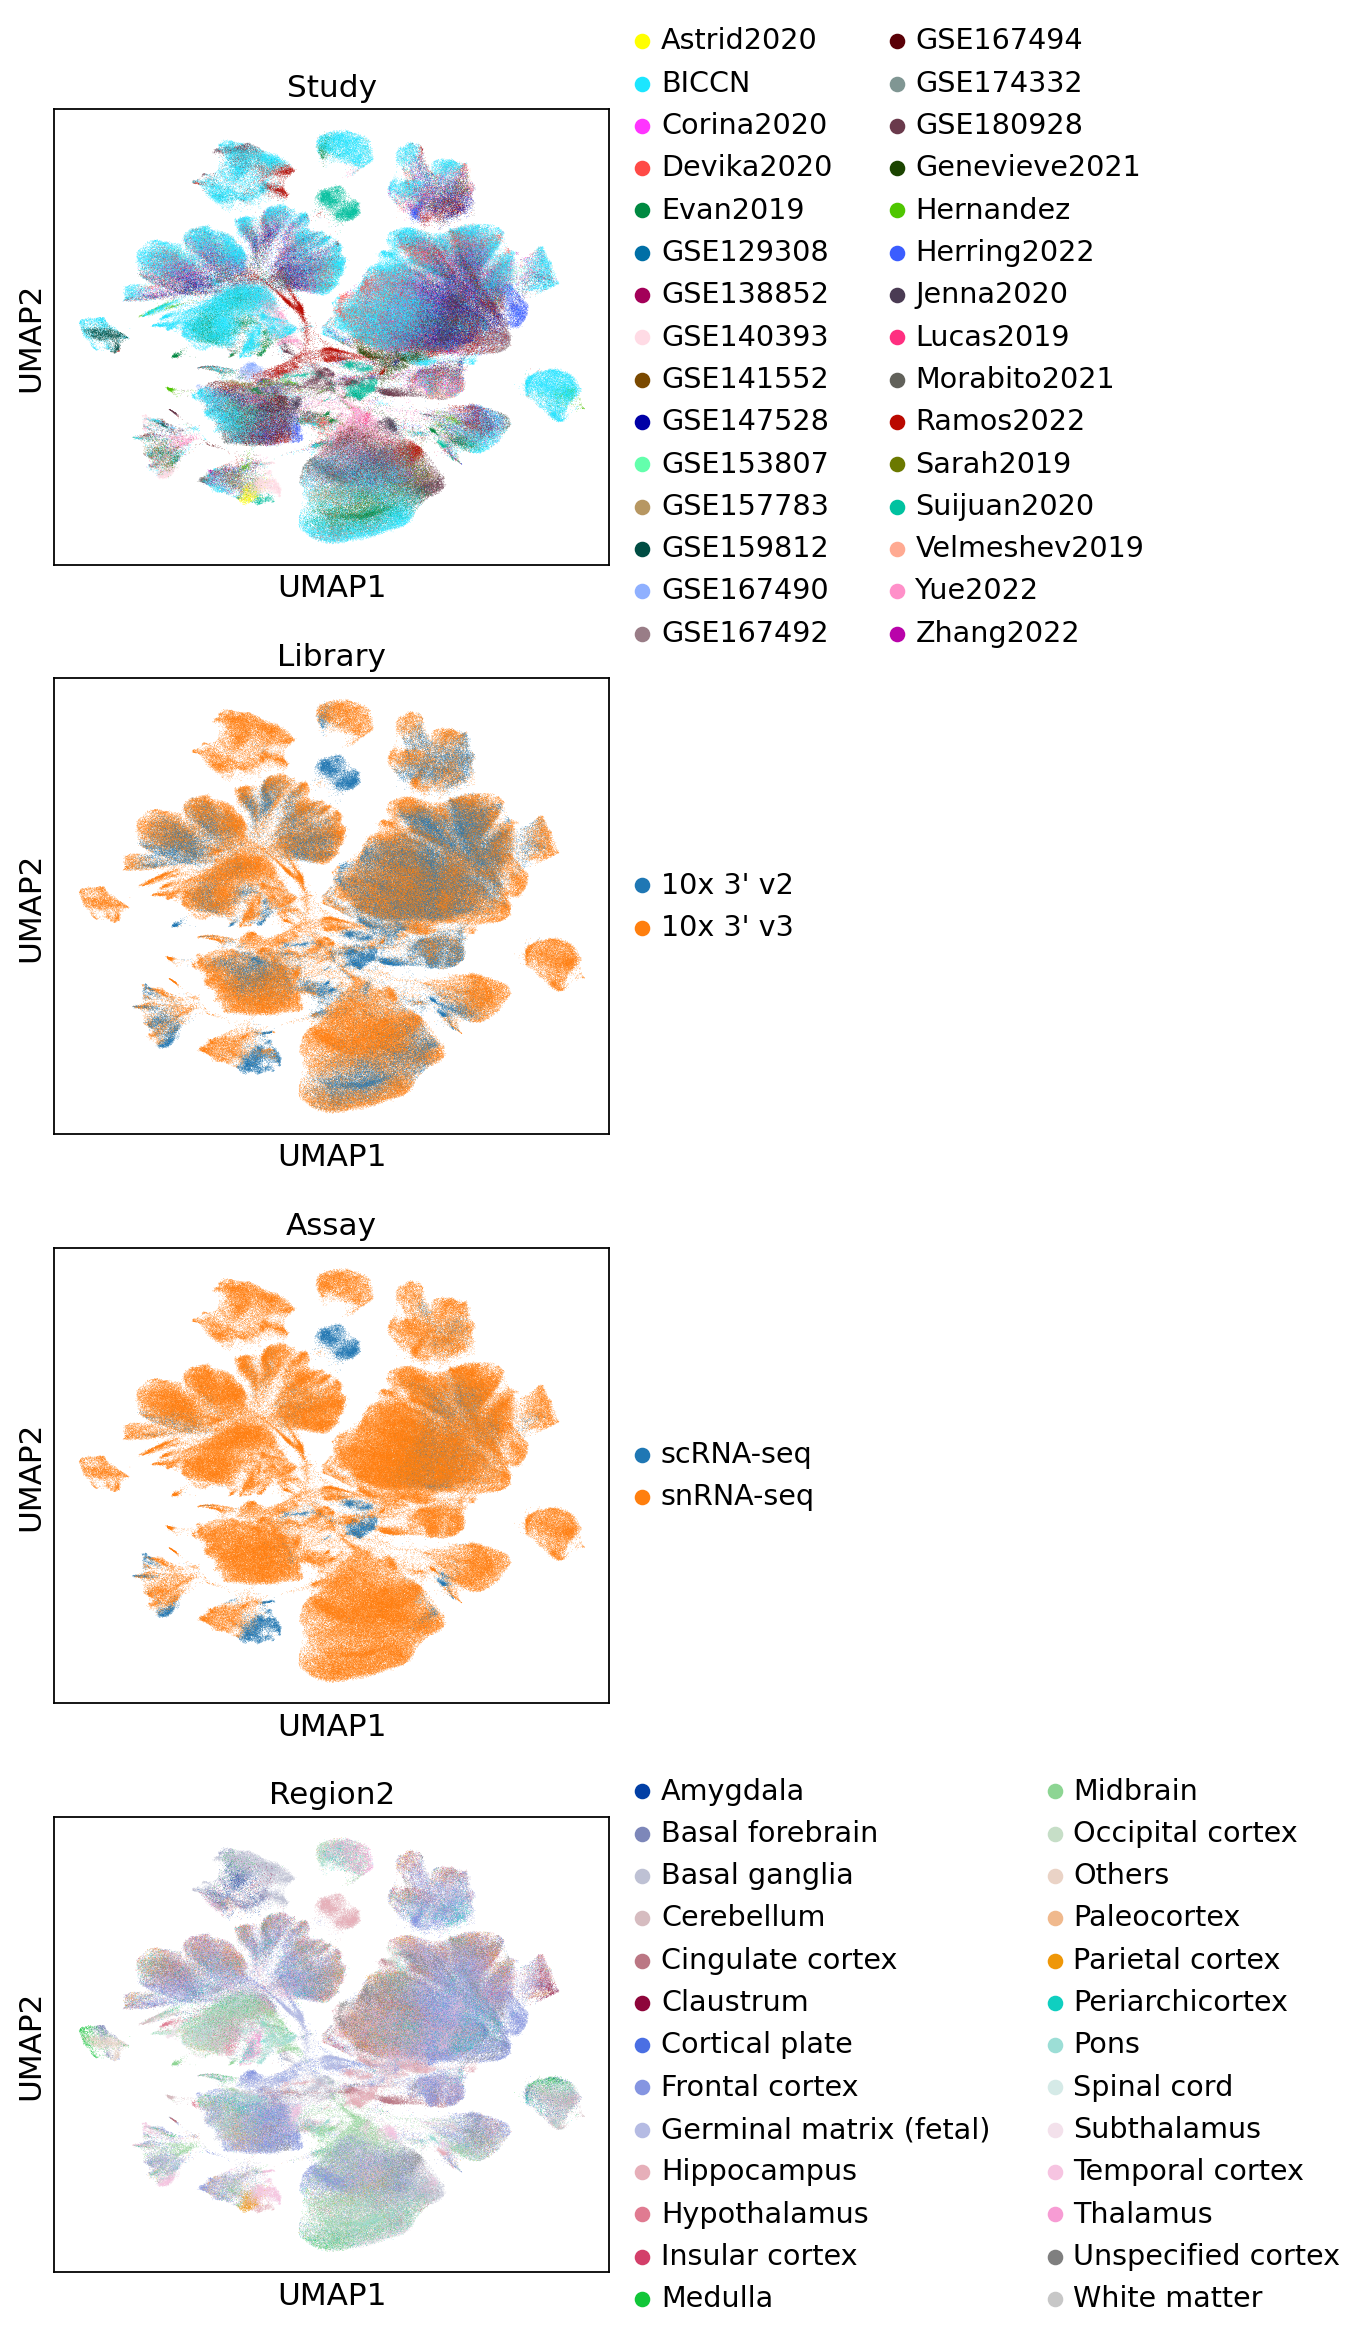

In [25]:
sc.pl.umap(adata_scvi, color=['Study', 'Library', 'Assay', 'Region2'], ncols=1)

In [26]:
adata_scvi

AnnData object with n_obs × n_vars = 492644 × 5000
    obs: 'SampleID', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'DonorID', 'Study', 'Series', 'PMID', 'publication_year', 'BioSample', 'Batch', 'Age', 'Age2', 'Stage', 'Region', 'PMI', 'Sex', 'Diagnosis', 'Instrument', 'Assay', 'Library', 'Category', 'redistributable', 'Region2', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'Study_colors', 'Library_colors', 'Assay_colors', 'Region2_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [27]:
adata_scvi.write('Output_BrainAtlas_5000hvg_scvi.20230918.h5ad')

In [28]:
sc.set_figure_params(vector_friendly=True)
col_dict_stage = {'Fetal (1st trimester)': '#ffd6b4',
            'Fetal (2nd trimester)': '#ffa357',
            'Fetal (3rd trimester)': '#c8873d',
            'Neonatal': '#fbcbe1',
            'Childhood (1-6Y)': '#f6b1d4',
            'Childhood (6-12Y)': '#f076b3',
            'Adolescence (12-20Y)': '#eb4f9e',
            'Adult (20-40Y)': '#b793db',
            'Adult (40-60Y)': '#9966cc',
            'Adult (60-80Y)': '#6b478e',
            'Adult (>80Y)': '#2d1e3d'}

In [32]:
adata_scvi.obs['Stage'] = pd.Categorical(adata_scvi.obs['Stage'], 
categories=['Fetal (2nd trimester)', 'Fetal (3rd trimester)', 'Neonatal', 'Childhood (1-6Y)', 'Childhood (6-12Y)', 'Adolescence (12-20Y)', 'Adult (20-40Y)', 'Adult (40-60Y)', 'Adult (60-80Y)', 'Adult (>80Y)'], ordered=True)				

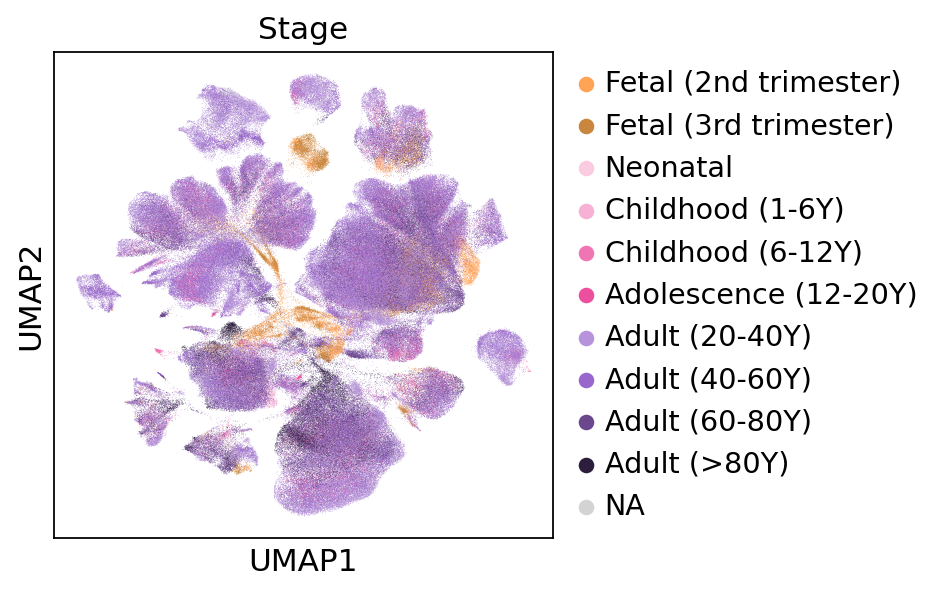

In [33]:
sc.pl.umap(adata_scvi, color='Stage', palette=col_dict_stage)

In [31]:
adata_scvi.obs['Study'].value_counts()

Study
BICCN            184927
Ramos2022         32959
Herring2022       32743
Velmeshev2019     28393
GSE180928         25314
Lucas2019         18395
GSE147528         17036
GSE129308         14303
Evan2019          13954
Devika2020        12404
Zhang2022         10000
Suijuan2020        9998
Morabito2021       9992
Corina2020         9588
Jenna2020          8954
GSE167494          8828
Yue2022            8826
Genevieve2021      7178
GSE157783          6462
Sarah2019          5777
GSE167490          5000
GSE174332          4986
GSE140393          4370
Hernandez          3096
GSE167492          2469
GSE153807          1914
GSE159812          1882
GSE138852          1139
Astrid2020         1137
GSE141552           620
Name: count, dtype: int64

In [5]:
adata_scvi = sc.read_h5ad('Output_BrainAtlas_5000hvg_scvi.20230918.h5ad')

In [7]:
sc.tl.leiden(adata_scvi, resolution=1.5, key_added='leiden3')

In [8]:
adata_scvi.write('Output_BrainAtlas_5000hvg_scvi_leiden3_added.20230918.h5ad')